In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

## Histogramas

Un histograma es una visualizacion de datos donde se definen "contenedores" (rangos de valores) para una variable, y se cuenta la canitdad de puntos de datos dentro de cada contenedor.

De esta forma, podemos visualizar la distribucion de la variable.

*Ejemplo:*

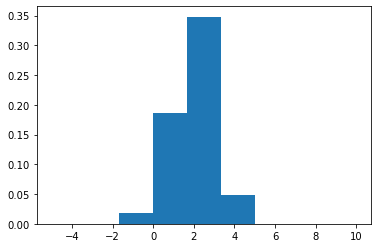

In [2]:
np.random.seed(1)
xs = np.random.normal(2, 1, 100).reshape(-1, 1)  # Obtengo 100 valores dados con una distribucion normal de media: 2 y desvio estandar: 1

def plot_histogram(xs, x_range, n_containers, axes=plt):
    interval_containers = np.linspace(x_range[0], x_range[1], n_containers)
    return axes.hist(xs, interval_containers, density=True)

plot_histogram(xs, (-5, 10), 10)
plt.show()

Esta forma de visualizar los datos tiene un problema: el grafico obtenido varia mucho según la cantidad de contenedores elegida.

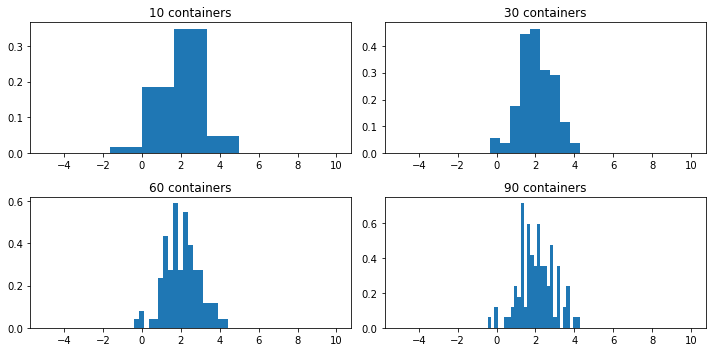

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

sample_containers = np.array([[10, 30], [60, 90]])

for i in range(2):
    for j in range(2):
        n_containers = sample_containers[i, j]
        axs[i, j].set_title(f"{n_containers} containers")
        plot_histogram(xs, (-5, 10), n_containers, axes=axs[i, j])

plt.tight_layout()
plt.show()

Para evitar este problema podemos utilizar **estimadores de densidad**:

Un *estimador de densidad* es una funcion que estima la densidad de cualquier valor respecto a la distribucion de nuestros puntos.

Podemos controlar la forma del estimador indicandole la forma de distribucion de nuestra variable (*kernel*):
- *gaussian*
- *tophat*
- *epanechnikov*
- *exponential*
- *linear*
- *cosine*

Y un parametro ***bandwidth*** que vale 1 por defecto.

De esta forma, podemos obtener graficos mucho mas suaves:

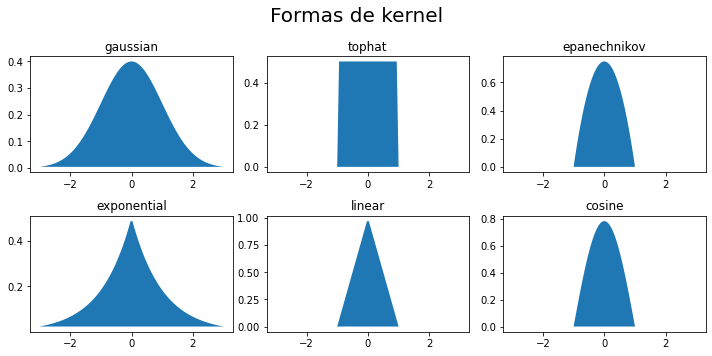

In [4]:
from sklearn.neighbors import KernelDensity

variable = np.zeros((1, 1))

domain = np.linspace(-3, 3, 100).reshape(-1, 1)
sample_kernels = np.array(['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear','cosine']).reshape(2, 3)

fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i in range(2):
    for j in range(3):
        kernel = sample_kernels[i, j]
        axs[i, j].set_title(kernel)
        d_estimator = KernelDensity(kernel=kernel).fit(variable)
        scores = d_estimator.score_samples(domain)
        axs[i, j].fill(domain, np.exp(scores))
        
fig.suptitle("Formas de kernel", fontsize=20)
plt.tight_layout()
plt.show()

- Es importante notar que `KernelDensity.score_samples()` retorna el `ln(densidad)` de cada punto
- Por esa razón, para utilizar los valores de densidad hacemos `np.exp(scores)`

Aplicando el estimador a al ejemplo:

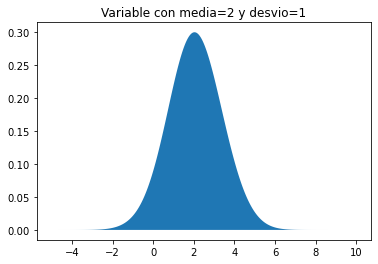

In [32]:
d_estimator = KernelDensity(kernel='gaussian').fit(xs)
domain = np.linspace(-5, 10, 1000).reshape(-1, 1)
scores = d_estimator.score_samples(domain)

plt.title("Variable con media=2 y desvio=1")
plt.fill(domain, np.exp(scores))
plt.show()

<br/>

## Modelos de redes neuronales

Una red neuronal es una representación simplificada de cómo piensan las neuronas en un cerebro humano.

Una neurona es como una función, toma varias entradas y calcula una salida. Las neuronas se conectan con otras, por lo tanto, la salida de una es una de las entradas de otra.

Podemos graficar un conjunto de neuronas y sus conexiones (red neuronal) a través de un grafo, donde cada nodo representa una neurona:

![Imagen grafo](https://scikit-learn.org/stable/_images/rbm_graph.png)

### Funcionamiento de la red

Una red neuronal puede contener multiples niveles que podemos clasificar en 3 grupos: *entrada*, *capa oculta* y *salida*.

El nivel de *entrada* está compuesto por todos los nodos en el primer nivel de la red, su salida se corresponderá con el input del sistema (el valor del punto que se quiere evaluar).

El nivel de *salida* esta compuesto por todos los nodos en el ultimo nivel del grafo, su salida se corresponderá con el output del sistema (el resultado, la predicción).

Los niveles *ocultos* son todos los niveles intermedios de la red, aquellos que se encuentran entre el nivel de *entrada* y el de *salida*.

![Red neuronal con descripcion de capas](https://miro.medium.com/max/700/0*hzIQ5Fs-g8iBpVWq.jpg)

Cada neurona, dado un input, se "activa", produciendo un valor de salida entre 0 y 1. Cuanto mas cerca del 1, mas activa, cuanto mas cerca del 0, menos.

##### Input
El input de cada neurona se calcula mediante la suma de todos outputs de las neuronas conectadas a ella en el nivel anterior. Es decir, la activación de las neuronas afectan a las neuronas con las que estan conectadas.

Una neurona no afecta a todas sus conexiones por igual, puede afectar a una en menor o mayor medida que a otras. Por eso decimos que cada conexion entre neuronas tiene asociado un peso (**weight**) que indica con que magnitud afecta una neurona a la otra.

Por otro lado, no todas las neuronas son igual de faciles de *activar*, por eso, cada neurona tiene asociado un **bias** que aumenta o disminuye la facilidad con la que se activa.

Por lo tanto, el input de una neurona *i* estará dado por:

![equation](https://latex.codecogs.com/gif.latex?input_{i}&space;=&space;w_{0}*a_{0}&space;&plus;&space;w_{1}*a_{1}&space;&plus;&space;...&space;&plus;&space;w_{n}*a_{n}&space;&plus;&space;b_{i})
- La suma ponderada de las activaciones u outputs de las neuronas del nivel anterior + el *bias* de la propia neurona

##### Output
El input obtenido puede ser cualquier valor real, por lo tanto, debe ser convertido a uno entre (0, 1) que será el output.

Para ello se utiliza una funcion que convierta el valor recibido a otro entre 0 y 1. Como:

![Funcion image](https://saugatbhattarai.com.np/wp-content/uploads/2018/06/Reluvssigmoid.png)

- Cuanto mayor sea el input, mas cercano al 1 va a ser el output
- El *bias* de la neurona simula un desplazamiento de esta funcion, haciendo más o menos facil la activacion de la misma

A esta funcion la llamamos **funcion de activación**.

##### Conclusión:
- Las neuronas de entrada afectan al primer nivel oculto
- Luego todos los niveles de la capa oculta afectan a las neuronas del siguiente hasta llegar al nivel de salida
- Entonces el ultimo nivel, el de salida, tendrá las neuronas que representan la salida del proceso (el resultado, la predicción)

### Entrenamiento
El entrenamiento de la red conciste en encontrar la mejor combinacion de valores para todos los **pesos** y **biases** de forma que se minimice el "costo" o "error" promedio respecto a un conjunto de entrenamiento.

- Partiendo de un vector de pesos y biases arbitrario, se obtiene el resultado de procesar cada input del conjunto de prueba
- Luego se calcula el error de cada input a partir de la diferencia entre su resultado y el valor "real" o "deseado"
- Finalmente se obtiene el error promedio entre todos los elementos del conjunto de entrenamiento
- Si el error promedio no es lo "suficientemente" chico, se modifican los valores de los pesos y biases utilizando el negativo del gradiente de la función de costo (la dirección en la que mas rapido disminuye) y se vuelve a repetir el proceso

Este algoritmo se conoce como **_gradient decent_**.

*Para mas información sobre el funcionamiento de las redes y del algoritmo de entrenamiento recomiendo esta playlist: [Neural Networks - 3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)*

<br/>

### Ejemplo 1: *sklearn*

Una forma de crear rapidamente un modelo de red neuronal es utilizando la clase `MLPClassifier` (Multi-Layer Perception Classifier) de `sklearn.neural_network`.

Para este ejemplo vamos a clasificar, nuevamente, el dataset `iris`:

In [35]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
data = iris.data
target = iris.target

train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=0.9)  # 90% de entrenamiento

In [94]:
from sklearn.neural_network import MLPClassifier

neural_network = MLPClassifier(max_iter=2000, hidden_layer_sizes=(7, 7), activation='relu')
neural_network.fit(train_data, train_target)

score = neural_network.score(test_data, test_target)
print(f"Porcentaje de coincidencia: {round(score * 100, 2)}%")

Porcentaje de coincidencia: 93.33%


- Definimos una red con 2 niveles ocultos de 7 neuronas cada uno
- La capa de entrada tiene la misma cantidad de neuronas como caracteristicas del input
- La capa de salida tiene la misma cantidad de neuronas como clasificaciones posibles, dadas por el target

Para lograr la convergencia de la red, se puede modificar el parametro de `max_iter` que indica el numero maximo de iteraciones de "*gradient descent*" que llevará a cabo el algoritmo de entrenamiento.

Otra forma de lograrlo es aumentando el numero de capas ocultas o bien el numero de neuronas por capa modificando el parametro `hidden_layer_sizes`. Una lista de la cantidad de neuronas que tendrá cada nivel.
- Este ultimo permite lograr la convergencia con un menor numero de iteraciones, pero aumenta la cantidad de *pesos* y *biases* para procesar

<br/>

### Ejemplo 2: *TensorFlow*